In [1]:
# Load Libraries
import dash
from dash import dcc, html, Input, Output
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

### Question 1: Does the species data from 15 most visited parks reflect the pyramid of number/biomass (Food chain pyramid)?

In [2]:
file_path = 'most_visited_nps_species_data_tidy.csv'

df = pd.read_csv(file_path)

# Define food chain pyramid order
food_chain_order = {
    "Vascular Plant": 1,
    "Non-vascular Plant": 1,
    "Chromista": 1,
    "Fungi": 2,
    "Insect": 3,
    "Spider/Scorpion": 3,
    "Other Non-vertebrates": 3,
    "Fish": 4,
    "Bird": 5,
    "Mammal": 6,
}

# Map CategoryName with foodchain level
df["FoodChainLevel"] = df["CategoryName"].map(food_chain_order)

# Group CategoryName with foodchain level and sort order
def filter_data(parks):
    filtered_df = df[df['ParkName'].isin(parks)]
    aggregated_df = (
        filtered_df.groupby(['CategoryName', 'FoodChainLevel'])['References']
        .sum()
        .reset_index()
    )
    return aggregated_df

# Dash App
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("National Park Species References"),

    # Create drop down menu for Park filter
    dcc.Dropdown(
        id='park-dropdown',
        options=[{'label': park, 'value': park} for park in df['ParkName'].unique()],
        multi=True,
        value=[df['ParkName'].unique()[0]],
        clearable=False
    ),

    dcc.Graph(id='scatter-plot'),
    dcc.Graph(id='bar-chart')
])

# Scatter plot
@app.callback(
    Output('scatter-plot', 'figure'),
    Input('park-dropdown', 'value')
)
def update_scatter(selected_parks):
    data = filter_data(selected_parks)
    data = data.sort_values("FoodChainLevel")

    fig = px.scatter(
        data,
        x='FoodChainLevel',
        y='References',
        title=f"Species References in Selected Parks",
        labels={'FoodChainLevel': 'Food Chain Level', 'References': 'Total References'},
        size='References',
        size_max=60,  # Increase this value to make dots larger
        color='CategoryName',  # Add color
        hover_data=['CategoryName']
    )

    # Compute regression line
    x = data['FoodChainLevel']
    y = data['References']
    if len(x) > 1:  # Ensure enough data points for regression
        slope, intercept = np.polyfit(x, y, 1)
        regression_y = slope * x + intercept

        fig.add_trace(
            go.Scatter(
                x=x, y=regression_y,
                mode='lines',
                name='Regression Line',
                line=dict(color='red'))
        )
    return fig

# Bar chart
@app.callback(
    Output('bar-chart', 'figure'),
    Input('scatter-plot', 'clickData')
)
def update_bar_chart(clickData):
    if clickData is None:
        return px.bar(title="Select a Category to see Top 10 Common Names")

    # Access click data
    category_name = clickData['points'][0]['customdata'][0]
    print("selected_category: ", category_name)

    filtered_df = df[df['CategoryName'] == category_name].copy()

    # Check if CommonNames exist
    if 'CommonNames' in filtered_df.columns:
        # Extract first common name from comma-separated values
        filtered_df['PrimaryCommonName'] = filtered_df['CommonNames'].str.split(',').str[0]
    else:
        # If there is no CommonNames
        filtered_df['PrimaryCommonName'] = filtered_df['ScientificName']

    # Get top 10 Common names
    top_common_names = (filtered_df.groupby('PrimaryCommonName')['References'].sum().reset_index().nlargest(10, 'References'))

    fig = px.bar(
        top_common_names,
        x='PrimaryCommonName',
        y='References',
        title=f"Top 10 Common Names in {category_name}",
        labels={'PrimaryCommonName': 'Common Name', 'References': 'Total References'}
    )
    return fig


if __name__ == '__main__':
    app.run(jupyter_height=1000)   # Run app

selected_category:  Mammal


### Question 2: What proportion of species are endangered, threatened, or of special concern? 

In [3]:
# Set the style for plots
plt.style.use('seaborn-v0_8-whitegrid')
colors = ['#766CDB', '#DA847C', '#D9CC8B', '#7CD9A5', '#877877', '#52515E']

# Set plot dimensions and layout
plt.rcParams['figure.figsize'] = (9, 6)
plt.rcParams['axes.titlepad'] = 15
plt.rcParams['axes.labelpad'] = 10
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.title_fontsize'] = 14

Data Loading and Preprocessing

In [4]:
# Load the data
df = pd.read_csv('most_visited_nps_species_data_tidy.csv')
print(f"Loaded data with {df.shape[0]} rows and {df.shape[1]} columns")
df.head()

Loaded data with 61119 rows and 28 columns


,ParkCode,ParkName,CategoryName,Order,Family,TaxonRecordStatus,SciName,CommonNames,Synonyms,ParkAccepted,...,ParkTags,References,Observations,Vouchers,ExternalLinks,TEStatus,StateStatus,OzoneSensitiveStatus,GRank,SRank
0,ACAD,Acadia National Park,Mammal,Artiodactyla,Cervidae,Active,Alces alces,Moose,NaN,True,...,NaN,11,1,0,NaN,50,NaN,NaN,G5,ME: S5
1,ACAD,Acadia National Park,Mammal,Artiodactyla,Cervidae,Active,Odocoileus virginianus,Northern White-tailed Deer,NaN,True,...,NaN,20,0,0,NaN,50,NaN,NaN,G5,ME: S5
2,ACAD,Acadia National Park,Mammal,Carnivora,Canidae,Active,Canis latrans,Coyote,NaN,True,...,NaN,8,1,0,NaN,SC,NaN,NaN,G5,ME: S5
3,ACAD,Acadia National Park,Mammal,Carnivora,Canidae,Active,Canis lupus,Eastern Timber Wolf,NaN,True,...,NaN,2,0,0,NaN,E,NaN,NaN,G5,ME: SH
4,ACAD,Acadia National Park,Mammal,Carnivora,Canidae,Active,Vulpes vulpes,Black Fox,NaN,True,...,NaN,16,0,0,NaN,NaN,NaN,NaN,G5,ME: S5


In [5]:
# Data preprocessing
# Fill NaN values with empty strings for easier processing
df['TEStatus'] = df['TEStatus'].fillna('')
df['StateStatus'] = df['StateStatus'].fillna('')

# Create a new column for conservation status
def get_conservation_status(row):
    # Check federal status first (TEStatus)
    if pd.notna(row['TEStatus']) and row['TEStatus'] in ['E', 'T']:
        return 'Endangered/Threatened'
    elif pd.notna(row['TEStatus']) and row['TEStatus'] in ['SC', 'C']:
        return 'Special Concern'
    # Then check state status
    elif pd.notna(row['StateStatus']) and row['StateStatus'] in ['SE', 'ST']:
        return 'Endangered/Threatened'
    elif pd.notna(row['StateStatus']) and row['StateStatus'] in ['SC']:
        return 'Special Concern'
    else:
        return 'Not Listed'

df['ConservationStatus'] = df.apply(get_conservation_status, axis=1)

# Create a summary dataframe
park_stats = pd.DataFrame({
    'TotalSpecies': df.groupby('ParkName').size(),
    'EndangeredCount': df[df['ConservationStatus'] == 'Endangered/Threatened'].groupby('ParkName').size(),
    'SpecialConcernCount': df[df['ConservationStatus'] == 'Special Concern'].groupby('ParkName').size()
}).fillna(0).astype(int)

park_stats['EndangeredPercent'] = park_stats['EndangeredCount'] / park_stats['TotalSpecies'] * 100
park_stats['SpecialConcernPercent'] = park_stats['SpecialConcernCount'] / park_stats['TotalSpecies'] * 100

park_stats.head()


,TotalSpecies,EndangeredCount,SpecialConcernCount,EndangeredPercent,SpecialConcernPercent
ParkName,,,,,
Acadia National Park,1709,3,160,0.175541,9.362200
Bryce Canyon National Park,1287,3,116,0.233100,9.013209
Cuyahoga Valley National Park,1942,2,104,0.102987,5.355304
Glacier National Park,2559,4,131,0.156311,5.119187
Grand Canyon National Park,2708,13,213,0.480059,7.865583


#### Chart 1: Biodiversity in Most Visited National Parks

In [6]:
# Get the most visited parks (we'll use the ones with the most species for this example)
most_visited_parks = park_stats.sort_values('TotalSpecies', ascending=False).head(10).index.tolist()
print(f"Top 10 parks by species count: {most_visited_parks}")

# Filter the dataframe for these parks
most_visited_df = df[df['ParkName'].isin(most_visited_parks)]

# Count species by category for each park
biodiversity_data = pd.crosstab(most_visited_df['ParkName'], most_visited_df['CategoryName'])

# Sort parks by total species count
biodiversity_data = biodiversity_data.loc[park_stats.loc[biodiversity_data.index]['TotalSpecies'].sort_values(ascending=False).index]

# Display the biodiversity data
biodiversity_data.head()


Top 10 parks by species count: ['Great Smoky Mountains National Park', 'Yellowstone National Park', 'Rocky Mountain National Park', 'Grand Canyon National Park', 'Glacier National Park', 'Indiana Dunes National Park', 'Joshua Tree National Park', 'Grand Teton National Park', 'Yosemite National Park', 'Hot Springs National Park']


CategoryName,Amphibian,Bacteria,Bird,Chromista,Crab/Lobster/Shrimp,Fish,Fungi,Insect,Mammal,Non-vascular Plant,Other Non-vertebrates,Protozoa,Reptile,Slug/Snail,Spider/Scorpion,Vascular Plant
ParkName,,,,,,,,,,,,,,,,
Great Smoky Mountains National Park,58,294,267,654,125,110,5243,12398,101,1039,993,257,47,291,4630,2163
Yellowstone National Park,9,4,330,204,64,19,37,1764,78,15,80,18,9,61,43,1444
Rocky Mountain National Park,5,45,278,150,39,12,306,676,75,416,48,9,3,10,22,1119
Grand Canyon National Park,15,0,456,0,2,29,0,125,107,0,1,0,76,2,142,1753
Glacier National Park,6,0,277,2,6,27,276,197,69,404,2,0,4,20,0,1269


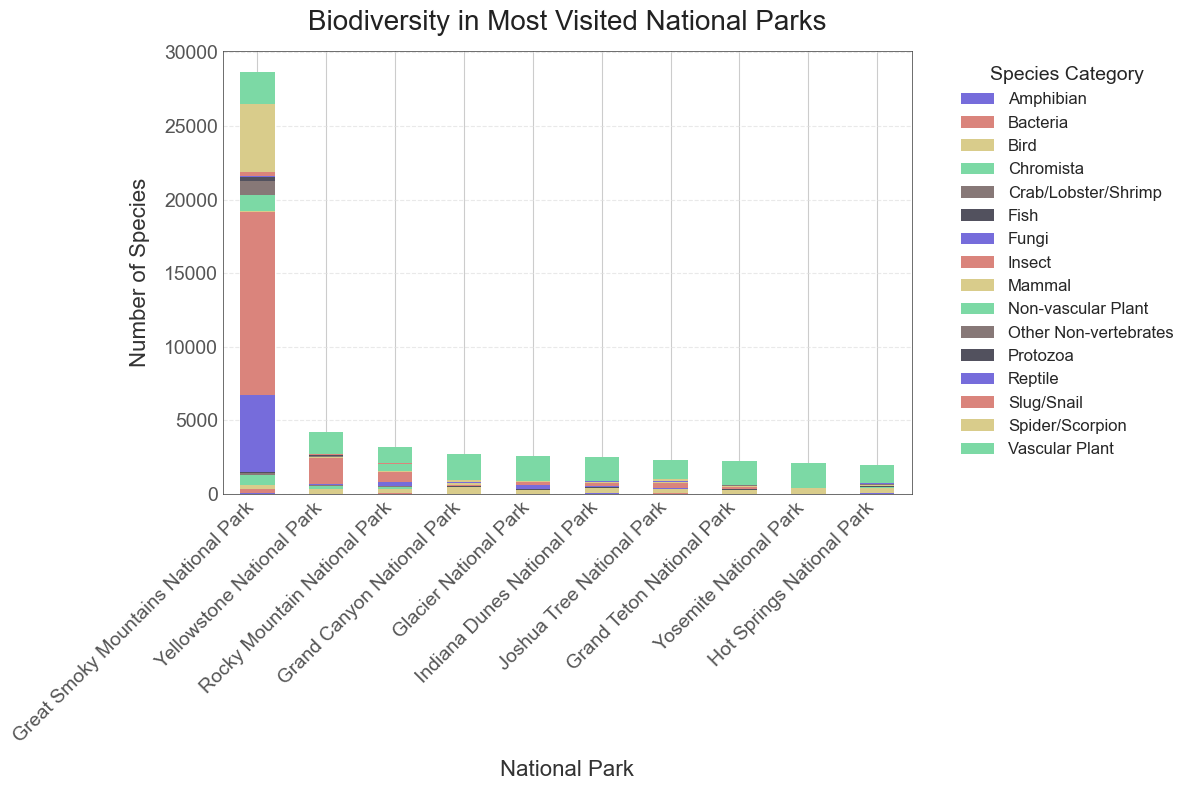

In [7]:
# Create a stacked bar chart for biodiversity
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_axisbelow(True)

biodiversity_data.plot(
    kind='bar', 
    stacked=True, 
    color=colors[:len(biodiversity_data.columns)], 
    ax=ax
)

ax.set_title('Biodiversity in Most Visited National Parks', fontsize=20, pad=15, color='#222222')
ax.set_xlabel('National Park', fontsize=16, labelpad=10, color='#333333')
ax.set_ylabel('Number of Species', fontsize=16, labelpad=10, color='#333333')
plt.xticks(rotation=45, ha='right', fontsize=14, color='#555555')
plt.yticks(fontsize=14, color='#555555')
ax.legend(title='Species Category', fontsize=12, title_fontsize=14, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', linestyle='--', alpha=0.7, color='#E0E0E0')

for spine in ax.spines.values():
    spine.set_color('#333333')
    spine.set_linewidth(0.5)

plt.tight_layout()
plt.savefig('biodiversity_in_most_visited_parks.png', dpi=300, bbox_inches='tight')
plt.show()


#### Chart 2: Create correlation chart with minimal English annotations

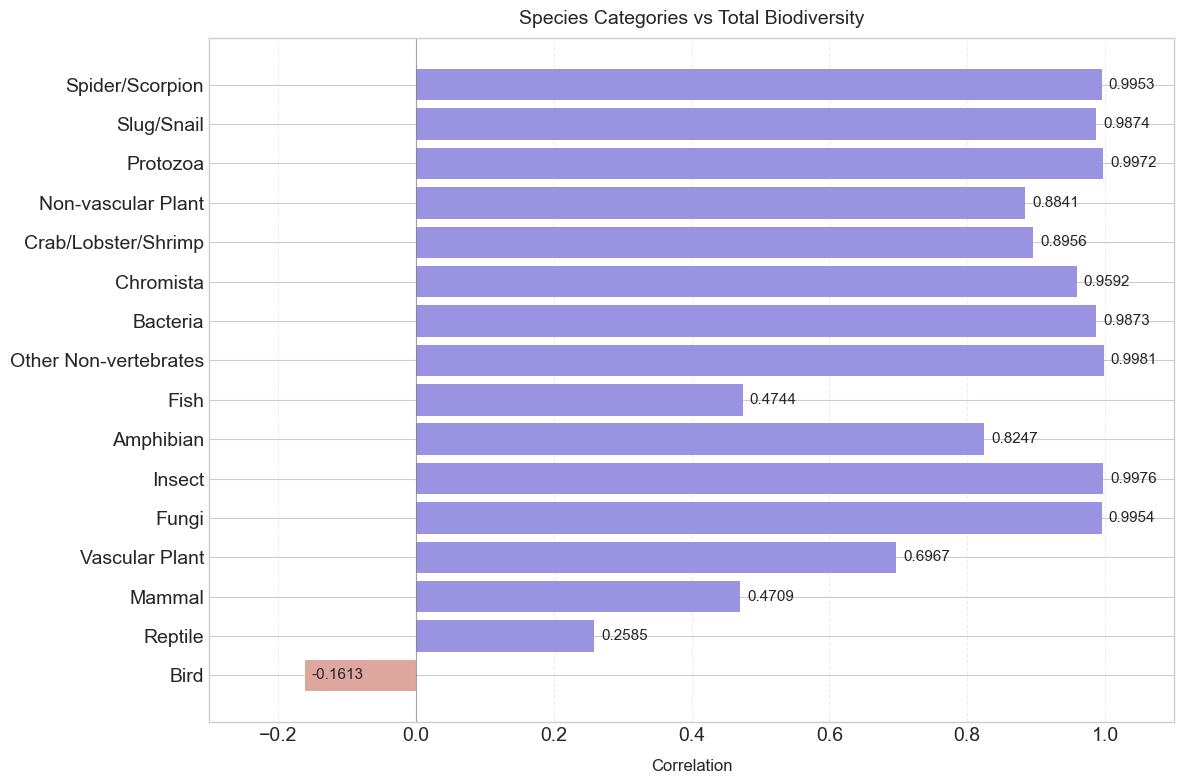

In [8]:

# Load the dataset
df = pd.read_csv('most_visited_nps_species_data_tidy.csv')

# Count species by park and category
species_by_park_category = df.groupby(['ParkName', 'CategoryName']).size().unstack(fill_value=0)

# Calculate total species richness for each park
species_by_park_category['Total'] = species_by_park_category.sum(axis=1)

# Calculate correlations
correlations = {}
for category in species_by_park_category.columns:
    if category != 'Total':
        corr = np.corrcoef(species_by_park_category[category], species_by_park_category['Total'])[0, 1]
        correlations[category] = corr

# Convert to DataFrame
corr_df = pd.DataFrame(list(correlations.items()), columns=['Category', 'Correlation'])

# Define exact order from original image
category_order = [
    'Bird', 'Reptile', 'Mammal', 'Vascular Plant', 'Fungi', 'Insect', 'Amphibian', 'Fish', 'Algae', 'Other Non-vertebrates'
]

# Sort DataFrame by defined order
corr_df['Order'] = corr_df['Category'].map({cat: i for i, cat in enumerate(category_order)})
corr_df = corr_df.sort_values('Order').drop('Order', axis=1)

# Create chart with new format
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})

# Color array: Bird is #DDA69F, others are #9A93E2
colors = ['#DDA69F' if category == 'Bird' else '#9A93E2' for category in corr_df['Category']]

# Draw horizontal bar chart
bars = plt.barh(corr_df['Category'], corr_df['Correlation'], color=colors)

# Add correlation values next to each bar with 4 decimal places
for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
             f"{corr_df['Correlation'].iloc[i]:.4f}", 
             va='center', fontsize=11)

# Customize axes and grid
plt.axvline(x=0, color='grey', linestyle='-', alpha=0.7, linewidth=0.8)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.xlim(-0.3, 1.1)

# Add minimal labels and title
plt.xlabel('Correlation', fontsize=12)
plt.title('Species Categories vs Total Biodiversity', fontsize=14, pad=10)
plt.ylabel('')

# Adjust layout and save
plt.tight_layout()
plt.savefig('species_correlation_minimal.png', dpi=300, bbox_inches='tight')

plt.show()


#### Chart 3: Create simplified bubble chart with random colors

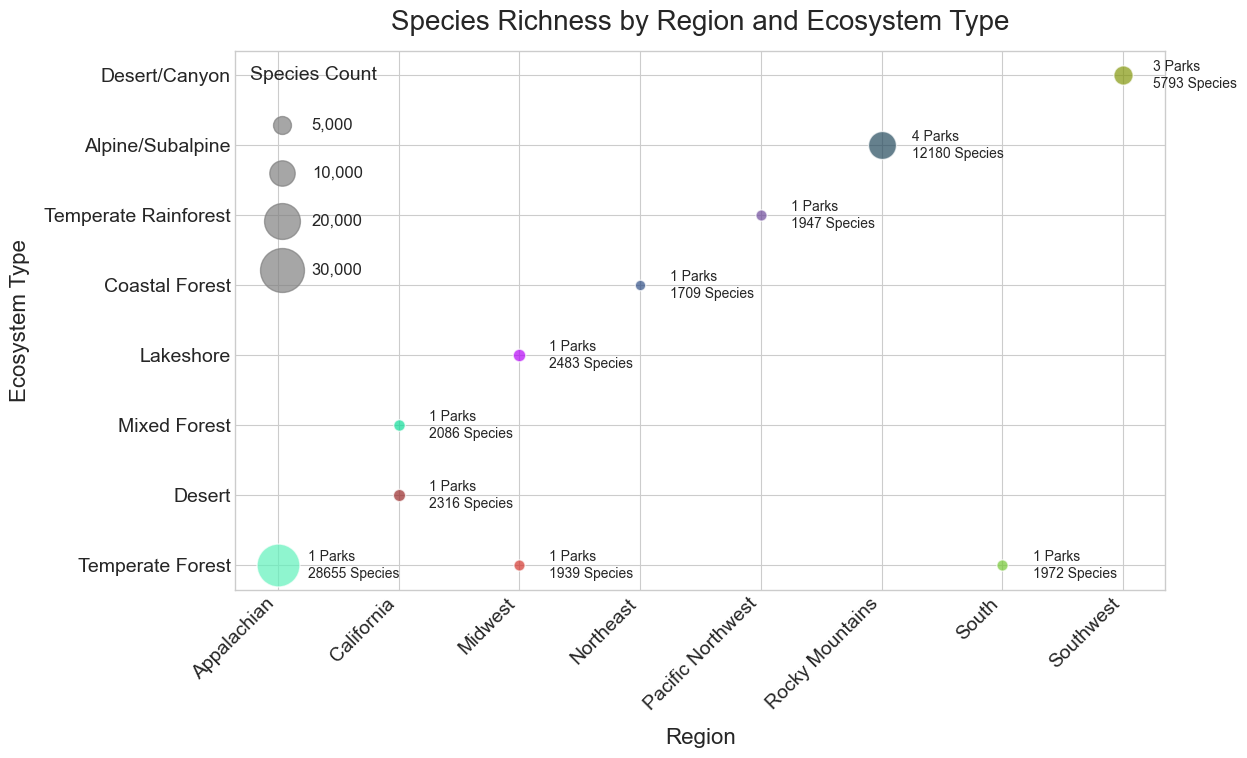

In [33]:
# Load the dataset
df = pd.read_csv('most_visited_nps_species_data_tidy.csv')

# Define regions and ecosystem types for each park
park_info = {
    'Acadia National Park': {'Region': 'Northeast', 'Ecosystem': 'Coastal Forest'},
    'Bryce Canyon National Park': {'Region': 'Southwest', 'Ecosystem': 'Desert/Canyon'},
    'Cuyahoga Valley National Park': {'Region': 'Midwest', 'Ecosystem': 'Temperate Forest'},
    'Glacier National Park': {'Region': 'Rocky Mountains', 'Ecosystem': 'Alpine/Subalpine'},
    'Grand Canyon National Park': {'Region': 'Southwest', 'Ecosystem': 'Desert/Canyon'},
    'Grand Teton National Park': {'Region': 'Rocky Mountains', 'Ecosystem': 'Alpine/Subalpine'},
    'Great Smoky Mountains National Park': {'Region': 'Appalachian', 'Ecosystem': 'Temperate Forest'},
    'Hot Springs National Park': {'Region': 'South', 'Ecosystem': 'Temperate Forest'},
    'Indiana Dunes National Park': {'Region': 'Midwest', 'Ecosystem': 'Lakeshore'},
    'Joshua Tree National Park': {'Region': 'California', 'Ecosystem': 'Desert'},
    'Olympic National Park': {'Region': 'Pacific Northwest', 'Ecosystem': 'Temperate Rainforest'},
    'Rocky Mountain National Park': {'Region': 'Rocky Mountains', 'Ecosystem': 'Alpine/Subalpine'},
    'Yellowstone National Park': {'Region': 'Rocky Mountains', 'Ecosystem': 'Alpine/Subalpine'},
    'Yosemite National Park': {'Region': 'California', 'Ecosystem': 'Mixed Forest'},
    'Zion National Park': {'Region': 'Southwest', 'Ecosystem': 'Desert/Canyon'}
}

# Count species by park
species_by_park = df.groupby('ParkName')['SciName'].nunique().reset_index()
species_by_park.columns = ['ParkName', 'SpeciesCount']

# Add region and ecosystem information
species_by_park['Region'] = species_by_park['ParkName'].map(lambda x: park_info[x]['Region'])
species_by_park['Ecosystem'] = species_by_park['ParkName'].map(lambda x: park_info[x]['Ecosystem'])

# Count parks by region and ecosystem
parks_by_region_ecosystem = species_by_park.groupby(['Region', 'Ecosystem']).size().reset_index()
parks_by_region_ecosystem.columns = ['Region', 'Ecosystem', 'ParkCount']

# Sum species by region and ecosystem
species_by_region_ecosystem = species_by_park.groupby(['Region', 'Ecosystem'])['SpeciesCount'].sum().reset_index()

# Merge park count and species count
region_ecosystem_data = pd.merge(parks_by_region_ecosystem, species_by_region_ecosystem, on=['Region', 'Ecosystem'])

# Create figure
plt.figure(figsize=(12, 7))

# Get unique regions and ecosystems
regions = region_ecosystem_data['Region'].unique()
ecosystems = region_ecosystem_data['Ecosystem'].unique()

# Create positions
region_positions = {region: i for i, region in enumerate(regions)}
ecosystem_positions = {ecosystem: i for i, ecosystem in enumerate(ecosystems)}

# Generate random colors for each ecosystem
np.random.seed(42)  # For reproducibility
colors = [np.random.rand(3,) for _ in range(len(region_ecosystem_data))]

# Create the bubble chart
for i, row in region_ecosystem_data.iterrows():
    x = region_positions[row['Region']]
    y = ecosystem_positions[row['Ecosystem']]
    size = row['SpeciesCount'] / 30
    
    plt.scatter(x, y, s=size, color=colors[i], alpha=0.7, edgecolor='white')
    plt.annotate(f"{row['ParkCount']} Parks\n{int(row['SpeciesCount'])} Species", 
                 (x + 0.25, y), ha='left', va='center', fontsize=10)

# Set labels and title
plt.xlabel('Region')
plt.ylabel('Ecosystem Type')
plt.title('Species Richness by Region and Ecosystem Type')

# Set tick labels
plt.xticks(range(len(regions)), regions, rotation=45, ha='right')
plt.yticks(range(len(ecosystems)), ecosystems)

# Add legend for bubble size
sizes = [5000, 10000, 20000, 30000]
labels = ['5,000', '10,000', '20,000', '30,000']
legend_bubbles = []

for size in sizes:
    legend_bubbles.append(plt.scatter([], [], s=size/30, color='gray', alpha=0.7))

plt.legend(legend_bubbles, labels, scatterpoints=1, title='Species Count', labelspacing = 2)

plt.savefig('species_richness_simple.png', dpi=300)
plt.show()
